# Testing the Untuned Results

In this notebook, we test the untuned results of the paper. The following steps will be performed:

1. Concatenate all the run results from our experiments into one DataFrame.  
2. Test the model performances using t-tests.  


Importing the necessary libraries:

In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp
import difflib

## Data Preparation


### Prepare results

First we need to put some structure into our run results. 

In [2]:
# Disclaimer: This code cell was partly written with LLM (ChatGPT) support
list_experiments = ["Untuned_epinions", "Untuned_amazon", "Untuned_movieLenz"]




mapping_experiment_name = {
    "Untuned_epinions": "epinions",
    "Untuned_amazon": "amazon",
    "Untuned_movieLenz": "movielens",
}

data_frames = []
for experiment in list_experiments:
    # Set the base directory where the run folders are stored
    base_dir = os.path.join("performance", experiment)

    # List to collect dataframes from each file

    # Iterate over each subdirectory (run folder) in the base directory
    for run_folder in os.listdir(base_dir):
        run_path = os.path.join(base_dir, run_folder)
        # Check if the item is a directory and its name starts with "run_"
        if os.path.isdir(run_path) and run_folder.startswith("run_"):
            # Extract run number (assuming folder names like "run_1", "run_2", etc.)
            run_number = int(run_folder.split("_")[-1])

            # Loop through files in the run folder
            for file_name in os.listdir(run_path):
                if file_name.endswith(".tsv"):
                    file_path = os.path.join(run_path, file_name)
                    # Read the TSV file
                    df = pd.read_csv(file_path, sep="\t")
                    # Add columns for the run number and file name for later identification
                    df["experiment"] = mapping_experiment_name[experiment]
                    df["run"] = run_number
                    df["file_name"] = file_name
                    # Optionally, you could also add the run folder name:
                    df["run_folder"] = run_folder

                    pattern = r"cutoff_(\d+)"
                    match = re.search(pattern, file_name)
                    if match:
                        cutoff_value = int(match.group(1))
                        df["cutoff"] = cutoff_value

                    data_frames.append(df)

    # Concatenate all dataframes along rows
df_experiments = pd.concat(data_frames, ignore_index=True)


df_experiments

,model,nDCG,MAP,MRR,Precision,Recall,F1,HR,experiment,run,file_name,run_folder,cutoff
0,NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256...,0.001989,0.000370,0.001183,0.000532,0.005842,0.000937,0.010434,epinions,30,rec_NeuMF_cutoff_20_relthreshold_0_2025_01_30_...,run_30,20
1,GeneralizedMF_seed=42_e=10_bs=512_lr=0$5_mffac...,0.004170,0.000567,0.002220,0.000497,0.014121,0.000938,0.024416,epinions,30,rec_cutoff_50_relthreshold_0_2025_01_30_03_56_...,run_30,50
2,NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256...,0.004043,0.000524,0.001745,0.000522,0.014383,0.000988,0.025876,epinions,30,rec_cutoff_50_relthreshold_0_2025_01_30_03_56_...,run_30,50
3,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.004039,0.000521,0.001739,0.000522,0.014383,0.000988,0.025876,epinions,30,rec_cutoff_50_relthreshold_0_2025_01_30_03_56_...,run_30,50
4,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.004100,0.000506,0.002918,0.000476,0.012138,0.000891,0.023372,epinions,30,rec_cutoff_50_relthreshold_0_2025_01_30_03_56_...,run_30,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.022058,0.004477,0.021478,0.004116,0.052602,0.007538,0.184037,movielens,7,rec_cutoff_50_relthreshold_0_2025_01_26_23_10_...,run_7,50
1967,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.034038,0.007227,0.036726,0.005963,0.075417,0.010925,0.268470,movielens,7,rec_cutoff_50_relthreshold_0_2025_01_26_23_10_...,run_7,50
1968,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.025100,0.005099,0.030870,0.004142,0.052775,0.007601,0.189974,movielens,7,rec_cutoff_50_relthreshold_0_2025_01_26_23_10_...,run_7,50
1969,ConvMF_seed=42_e=10_bs=32_lr=0$05_embedding_si...,0.025100,0.005099,0.030870,0.004142,0.052775,0.007601,0.189974,movielens,7,rec_cutoff_50_relthreshold_0_2025_01_26_23_10_...,run_7,50


Check for missing values outliers in duplicates. Some files in the run folders like 'rec_NeuMF_cutoff_10_relthreshold_0_2025_01_27_21_03_59' which only contain the NeuMF model are suspicous as the model is also in the "normal" performance file. Essentially this could mean that we have a lot of duplicates in the dataset.

In [3]:
print("Contains nulls:",sum(df_experiments.isna().sum())>0, "\n")


# If the values in these columns are duplicated, it means that one of the duplicated entries can be removed. 
subset_columns = [
'model',
'nDCG',
'MAP',
'MRR',
'Precision',
'Recall',
'F1',
'HR',
'experiment',
'run',
'cutoff'
 ]

print("Number of duplicates:" ,sum(df_experiments.duplicated(subset=subset_columns)))

df_experiments = df_experiments.sort_values(by=["experiment","run","file_name"], ascending=[True,True,False])

print("Subsample of duplicates:")

df_experiments[df_experiments.duplicated(subset=subset_columns)].head(10)


Contains nulls: False 

Number of duplicates: 219
Subsample of duplicates:


,model,nDCG,MAP,MRR,Precision,Recall,F1,HR,experiment,run,file_name,run_folder,cutoff
1079,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.003399,0.000475,0.001893,0.000466,0.010785,0.000880,0.022862,amazon,1,rec_NeuMF_cutoff_50_relthreshold_0_2025_02_01_...,run_1,50
1062,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001947,0.000456,0.001508,0.000508,0.004759,0.000895,0.010161,amazon,1,rec_NeuMF_cutoff_20_relthreshold_0_2025_02_01_...,run_1,20
1053,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001065,0.000391,0.001066,0.000402,0.002000,0.000648,0.004022,amazon,1,rec_NeuMF_cutoff_10_relthreshold_0_2025_02_01_...,run_1,10
864,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.003185,0.000425,0.002007,0.000420,0.009402,0.000790,0.020762,amazon,2,rec_NeuMF_cutoff_50_relthreshold_0_2025_02_01_...,run_2,50
881,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001962,0.000415,0.001675,0.000471,0.004392,0.000826,0.009418,amazon,2,rec_NeuMF_cutoff_20_relthreshold_0_2025_02_01_...,run_2,20
890,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001198,0.000446,0.001340,0.000385,0.001850,0.000603,0.003853,amazon,2,rec_NeuMF_cutoff_10_relthreshold_0_2025_02_01_...,run_2,10
963,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.003348,0.000448,0.001795,0.000434,0.010681,0.000819,0.021290,amazon,3,rec_NeuMF_cutoff_50_relthreshold_0_2025_02_01_...,run_3,50
954,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.002064,0.000425,0.001463,0.000516,0.005302,0.000900,0.010108,amazon,3,rec_NeuMF_cutoff_20_relthreshold_0_2025_02_01_...,run_3,20
953,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001091,0.000356,0.001003,0.000344,0.002183,0.000567,0.003441,amazon,3,rec_NeuMF_cutoff_10_relthreshold_0_2025_02_01_...,run_3,10
928,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.003578,0.000511,0.002107,0.000492,0.011236,0.000922,0.024390,amazon,4,rec_NeuMF_cutoff_50_relthreshold_0_2025_02_01_...,run_4,50


We can see that there a multiple duplicates. First we have to check if the number of rec_NeuMF files equals the number of duplicates

In [4]:
sum(df_experiments["file_name"].str.startswith("rec_NeuMF"))

219

The number of rec_NeuMF files and the number of duplicates is equal. That means we can drop them.

In [5]:
df_experiments = df_experiments[~df_experiments["file_name"].str.startswith("rec_NeuMF")]
print("Number of duplicates:" ,sum(df_experiments.duplicated(subset=subset_columns)))

Number of duplicates: 0


We only need a subset of columns and rows for the testing the reported values. The paper uses the nDCG@10 results (cutoff value of 10)

In [6]:
columns_to_keep = [
    "model",
    "nDCG",
    "experiment",
    "run",
    "cutoff"
]

df_experiments = df_experiments[columns_to_keep]
df_experiments = df_experiments[df_experiments["cutoff"] == 10]
df_experiments

,model,nDCG,experiment,run,cutoff
1071,GeneralizedMF_seed=42_e=15_bs=512_lr=0$07_mffa...,0.003706,amazon,1,10
1072,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001065,amazon,1,10
1073,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.002580,amazon,1,10
1074,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.004335,amazon,1,10
1075,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.002285,amazon,1,10
...,...,...,...,...,...
1173,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.008221,movielens,30,10
1174,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.012410,movielens,30,10
1175,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.012007,movielens,30,10
1176,ConvMF_seed=42_e=10_bs=32_lr=0$05_embedding_si...,0.012007,movielens,30,10


Finally we create a DataFrame with the performances noted in the paper.

In [7]:
# Disclaimer: This code cell was partly written with LLM (ChatGPT) support


list_experiments = ["Epinions/Untuned","Amazon/Untuned","Movielens_1m/Untuned"]


mapping_experiment_name = {
    "Epinions/Untuned": "epinions",
    "Amazon/Untuned": "amazon",
    "Movielens_1m/Untuned": "movielens",
}


data_frames = []
for experiment in list_experiments:

    # Set the base directory where the run folders are stored
    results_folder = os.path.join("Additional material", experiment)

    # List to collect dataframes from each file

    # Loop through files in the run folder
    for file_name in os.listdir(results_folder):
        if file_name.endswith(".tsv"):
            file_path = os.path.join(results_folder, file_name)
            # Read the TSV file
            df = pd.read_csv(file_path, sep="\t")
            # Add columns for the run number and file name for later identification
            df["experiment"] = mapping_experiment_name[experiment]
            df["file_name"] = file_name
            # Optionally, you could also add the run folder name:
            df["results_folder"] = results_folder


            pattern = r"cutoff_(\d+)"
            match = re.search(pattern, file_name)
            if match:
                cutoff_value = int(match.group(1))
                df["cutoff"] = cutoff_value
            
            
            data_frames.append(df)

df_results = pd.concat(data_frames, ignore_index=True)


# Remove 'run' as it is not present in df_results
subset_columns.remove("run")
columns_to_keep.remove("run")

print("Number of duplicates:" ,sum(df_results.duplicated(subset=subset_columns)))


df_results = df_results[columns_to_keep]
df_results = df_results[df_results["cutoff"] == 10]

df_results

Number of duplicates: 0


,model,nDCG,experiment,cutoff
8,GeneralizedMF_seed=42_e=10_bs=512_lr=0$5_mffac...,0.001836,epinions,10
9,NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256...,0.000811,epinions,10
10,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.001753,epinions,10
11,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.003049,epinions,10
12,MultiDAE_seed=42_e=10_bs=1024_intermediate_dim...,0.015473,epinions,10
13,ConvMF_seed=42_e=5_bs=32_lr=0$05_embedding_siz...,0.000811,epinions,10
14,ConvNeuMF_seed=42_e=5_bs=16_lr=0$05_embedding_...,0.005913,epinions,10
15,EASER_neighborhood=8444_l2_norm=3$72,0.135068,epinions,10
40,GeneralizedMF_seed=42_e=15_bs=512_lr=0$07_mffa...,0.000719,amazon,10
41,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.000437,amazon,10


In [8]:
df_experiments

,model,nDCG,experiment,run,cutoff
1071,GeneralizedMF_seed=42_e=15_bs=512_lr=0$07_mffa...,0.003706,amazon,1,10
1072,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.001065,amazon,1,10
1073,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.002580,amazon,1,10
1074,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.004335,amazon,1,10
1075,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.002285,amazon,1,10
...,...,...,...,...,...
1173,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.008221,movielens,30,10
1174,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.012410,movielens,30,10
1175,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.012007,movielens,30,10
1176,ConvMF_seed=42_e=10_bs=32_lr=0$05_embedding_si...,0.012007,movielens,30,10


## Perform t-test

### Test Epinions

In [9]:
df_epinions_experiments = df_experiments[df_experiments["experiment"] == "epinions"].copy()
df_epinions_results = df_results[df_results["experiment"] == "epinions"]
df_epinions_results.sort_values("nDCG", ascending=False)

,model,nDCG,experiment,cutoff
15,EASER_neighborhood=8444_l2_norm=3$72,0.135068,epinions,10
12,MultiDAE_seed=42_e=10_bs=1024_intermediate_dim...,0.015473,epinions,10
14,ConvNeuMF_seed=42_e=5_bs=16_lr=0$05_embedding_...,0.005913,epinions,10
11,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.003049,epinions,10
8,GeneralizedMF_seed=42_e=10_bs=512_lr=0$5_mffac...,0.001836,epinions,10
10,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.001753,epinions,10
9,NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256...,0.000811,epinions,10
13,ConvMF_seed=42_e=5_bs=32_lr=0$05_embedding_siz...,0.000811,epinions,10


For the Epinions dataset, the authors also reported values for the tuned EASER model, which is a shallow model. However in the paper directly they did not report the results for the untuned model. Therefore we exclude it from the tests.




In [10]:
df_epinions_experiments = df_epinions_experiments[~df_epinions_experiments["model"].str.startswith("EASER")] 
df_epinions_results = df_epinions_results[~df_epinions_results["model"].str.startswith("EASER")]

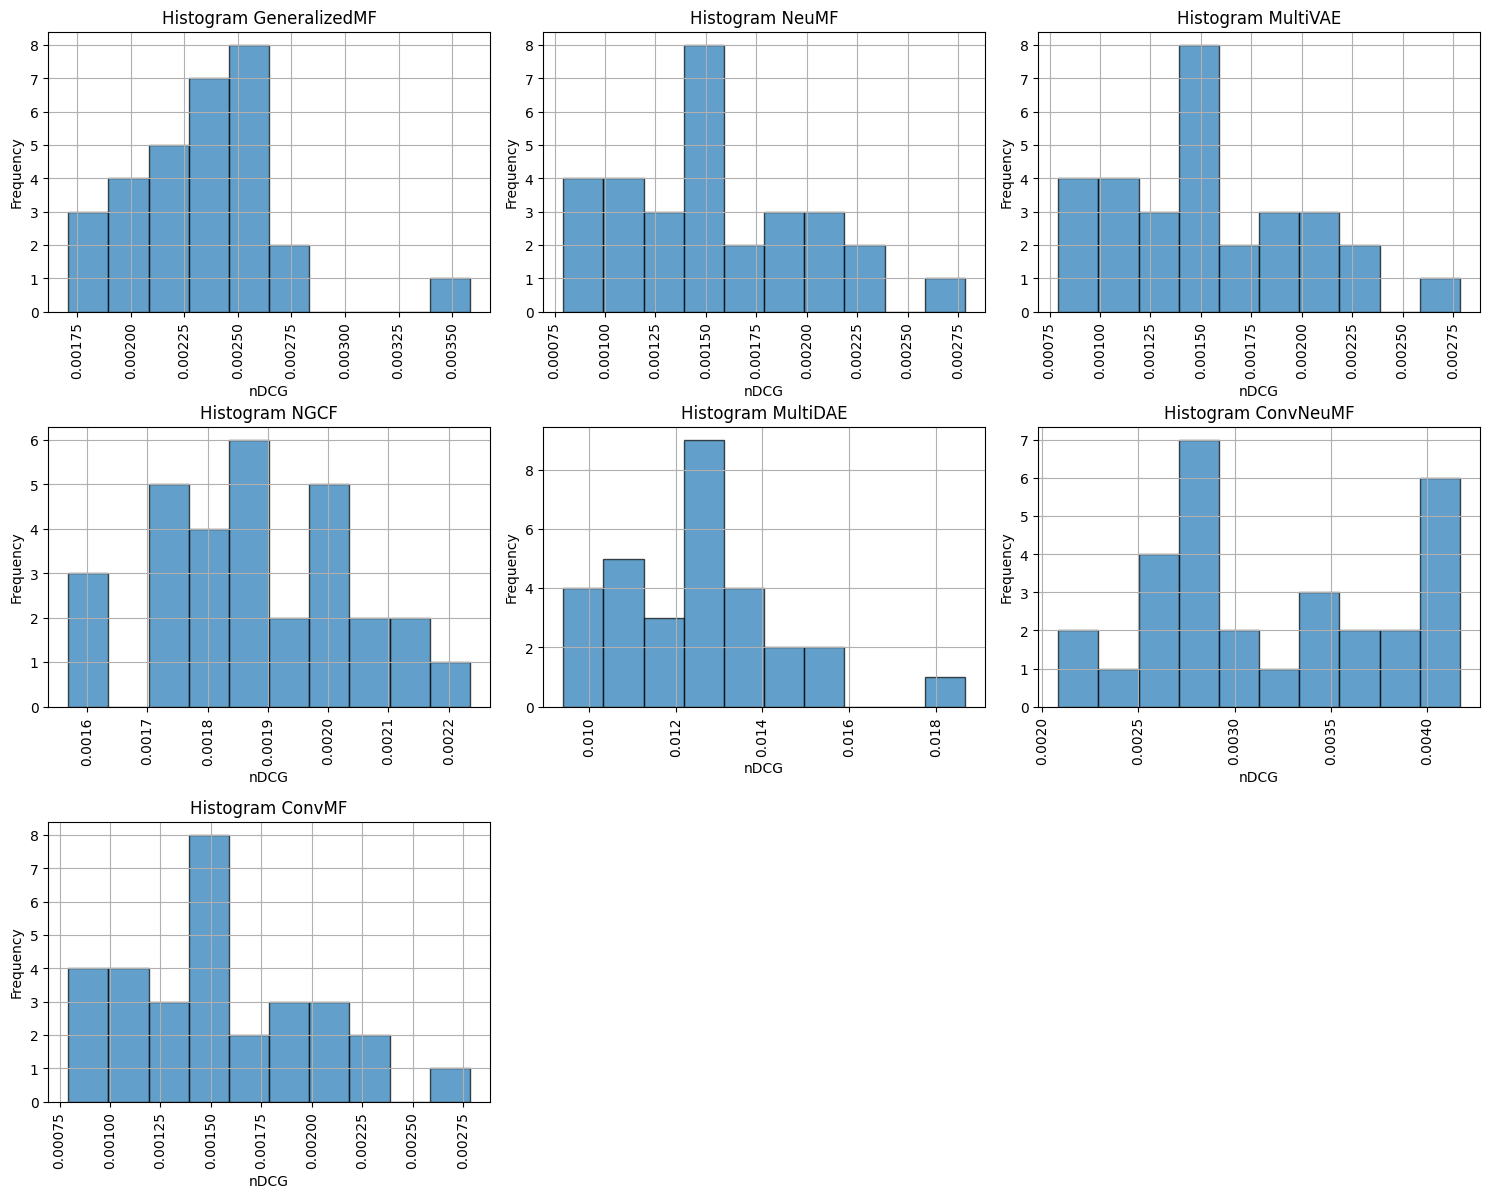

In [11]:
# Disclaimer: This cell was partly generated with the support of a LLM (ChatGPT)


models = df_epinions_experiments["model"].unique()
num_models = len(models)

# Define subplot grid (adjust for readability)
cols = 3  # Number of columns in the subplot grid
rows = int(np.ceil(num_models / cols))  # Calculate rows dynamically

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  
axes = axes.flatten()  # Flatten axes for easy iteration

# Loop through each model and plot the histogram in the corresponding subplot
for i, model in enumerate(models):
    df_plot = df_epinions_experiments[df_epinions_experiments["model"] == model]
    title = model.split("_")[0]  # Extract part of the model name

    axes[i].hist(df_plot["nDCG"], bins=10, alpha=0.7, edgecolor="black")  # Improved histogram
    axes[i].set_title(f"Histogram {title}", fontsize=12)
    axes[i].set_xlabel("nDCG")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)
    axes[i].tick_params(axis = "x",rotation = 90)

# Hide any unused subplots (if total models < grid size)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

While no distribution seems truly normally distributed, none appear significantly far from a normal distribution either, except maybe the GeneralizedMF distrbution. Since the tests are quite robust, we decided to proceed with the t-test for the Epinions dataset. 

The distributions for *ConvMF*, *MultiVAE* and *NeuMF* seem almost identical. Looking at the data through DataWrangler we can also observe that almost all values are the exact same. 


While trying to match the models from both datasets, we realized that some parameters used for the results model differ from those in the `untuned_epinions` config file (e.g., the number of epochs for MultiDAE). This should be criticized because the repository itself suggests that the results can be reproduced without any deeper configuration through the user, which is not entirely the case. As the runs where quite expensive we decide to keep our results but also keep this in mind as a limitation.


We now perform the test. Our H0 is that our sample mean is equal to the reported results which is interpreted as the population mean. Our H1 is that they are not equal. More formally:

$$
H_0: \ \mu_{sample} = \mu_0
$$

$$
H_1: \ \mu_{sample} \neq \mu_0
$$

We perform the test at a significance level of $\alpha = 0.05$

In [12]:

# Disclaimer: This Notebook Cell was partly created with an LLM (ChatGPT). It was used to improve the visual output of the test.


# To get rid of pandas warnings
df_epinions_experiments = df_epinions_experiments.copy()
df_epinions_results = df_epinions_results.copy()
df_epinions_experiments.loc[:,"model_name"] = df_epinions_experiments.loc[:,"model"].str.split("_").str[0]
df_epinions_results.loc[:,"model_name"] = df_epinions_results.loc[:,"model"].str.split("_").str[0]

# Create a list to store results
ttest_results = []

for model in df_epinions_experiments["model_name"].unique():
    result = df_epinions_results.loc[df_epinions_results["model_name"] == model, "nDCG"].item() 
    samples = df_epinions_experiments.loc[df_epinions_experiments["model_name"] == model, "nDCG"].to_numpy()
    
    # Perform t-test
    ttest_result = ttest_1samp(a=samples, popmean=result)
    
    # Store formatted results
    ttest_results.append({
        "Model": model,
        "Mean (Sample)": np.round(np.mean(samples), 5),
        "SD (Sample)" : np.round(np.std(samples),5),
        "Pop Mean (nDCG)": np.round(result, 5),
        "T-Statistic": np.round(ttest_result.statistic, 5),
        "p-Value": np.round(ttest_result.pvalue, 5),
        "Degrees of Freedom":(ttest_result.df),
        "Significant (p < 0.05)": "✅" if ttest_result.pvalue < 0.05 else "❌"
    })

# Convert to DataFrame for better display
df_ttest_results = pd.DataFrame(ttest_results)

df_ttest_results.sort_values(by = "Mean (Sample)", ascending=False)


,Model,Mean (Sample),SD (Sample),Pop Mean (nDCG),T-Statistic,p-Value,Degrees of Freedom,Significant (p < 0.05)
4,MultiDAE,0.01253,0.00195,0.01547,-8.12311,0.00000,29,✅
5,ConvNeuMF,0.00320,0.00062,0.00591,-23.57500,0.00000,29,✅
0,GeneralizedMF,0.00233,0.00036,0.00184,7.41918,0.00000,29,✅
3,NGCF,0.00187,0.00016,0.00305,-39.14303,0.00000,29,✅
1,NeuMF,0.00155,0.00047,0.00081,8.49854,0.00000,29,✅
2,MultiVAE,0.00155,0.00047,0.00175,-2.35932,0.02526,29,✅
6,ConvMF,0.00155,0.00047,0.00081,8.49854,0.00000,29,✅


We can reject $H_0$ for all models meaning our results are siginficantly different from the ones reported in the paper. See the report for more details.

Finally check which parameters differed between the models

In [13]:
# Disclaimer: This cell was partly generated with the support of a LLM (ChatGPT)


for model in df_epinions_experiments["model_name"].unique():

    
    
    print("=" * 30)
    print(model)

    model1 = df_epinions_experiments.loc[df_epinions_experiments["model_name"] == model, "model"].unique().item()
    model2 = df_epinions_results.loc[df_epinions_results["model_name"] == model, "model"].unique().item()

    # Use difflib to compare
    diff = list(difflib.ndiff(model1.split("_"), model2.split("_")))

    # Extract and print differences
    differences = []
    for d in diff:
        if d.startswith('- ') or d.startswith('+ '):
            key = d[2:].split("=")[0] if "=" in d else "Unknown"
            value = d[2:].split("=")[1] if "=" in d else d[2:]
            model_source = "Config File" if d.startswith("- ") else "Results File"
            differences.append((key, value, model_source))

    # Print results
    if differences:
        print("Differences found:\n")
        for param, value, model_source in differences:
            print(f"Parameter: {param}")
            print(f"   - {model_source}: {value}\n")
    else:
        print("No Differences Found Between Models")



GeneralizedMF
No Differences Found Between Models
NeuMF
No Differences Found Between Models
MultiVAE
No Differences Found Between Models
NGCF
No Differences Found Between Models
MultiDAE
Differences found:

Parameter: e
   - Config File: 5

Parameter: e
   - Results File: 10

ConvNeuMF
Differences found:

Parameter: e
   - Config File: 10

Parameter: e
   - Results File: 5

ConvMF
Differences found:

Parameter: e
   - Config File: 10

Parameter: e
   - Results File: 5



In [14]:
for model in models:
    print(model)
    print(sum(df_epinions_results["model"] == model))

GeneralizedMF_seed=42_e=10_bs=512_lr=0$5_mffactors=256_isedgeweighttrain=True
1
NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256_drop=0_batch_eval=256_mftrain=True_mlptrain=True_m=8
1
MultiVAE_seed=42_e=10_bs=256_intermediate_dim=800_latent_dim=400_reg_lambda=0$6_lr=0$6_dropout_pkeep=0$5
1
NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_w=0$4_weight_size=64_node_dropout=_message_dropout=0$4_n_fold=5
1
MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=600_latent_dim=200_reg_lambda=0$6_lr=0$7_dropout_pkeep=0$0
0
ConvNeuMF_seed=42_e=10_bs=16_lr=0$05_embedding_size=50_cnn_channels=1-16-16_cnn_kernels=2-2_cnn_strides=2-2_dropout_prob=0$5_l_w=0$08_l_b=0$07
0
ConvMF_seed=42_e=10_bs=32_lr=0$05_embedding_size=100_cnn_channels=1-32-32_cnn_kernels=2-2_cnn_strides=2-2_dropout_prob=0$4_l_w=0$03_l_b=0$04
0


In [15]:
# Define the two parameter strings
param_str1 = "ConvNeuMF_seed=42_e=10_bs=16_lr=0$05_embedding_size=50_cnn_channels=1-16-16_cnn_kernels=2-2_cnn_strides=2-2_dropout_prob=0$5_l_w=0$08_l_b=0$07"
param_str2 = "ConvNeuMF_seed=42_e=5_bs=16_lr=0$05_embedding_size=50_cnn_channels=1-16-16_cnn_kernels=2-2_cnn_strides=2-2_dropout_prob=0$5_l_w=0$08_l_b=0$07"

# Use difflib to compare
diff = list(difflib.ndiff(param_str1, param_str2))

# Extract differences
differences = [d for d in diff if d.startswith('- ') or d.startswith('+ ')]

# Format the results
diff_result = "\n".join(differences)
diff_result


'+ 5\n- 1\n- 0'

In [16]:
df_epinions_results

,model,nDCG,experiment,cutoff,model_name
8,GeneralizedMF_seed=42_e=10_bs=512_lr=0$5_mffac...,0.001836,epinions,10,GeneralizedMF
9,NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256...,0.000811,epinions,10,NeuMF
10,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.001753,epinions,10,MultiVAE
11,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.003049,epinions,10,NGCF
12,MultiDAE_seed=42_e=10_bs=1024_intermediate_dim...,0.015473,epinions,10,MultiDAE
13,ConvMF_seed=42_e=5_bs=32_lr=0$05_embedding_siz...,0.000811,epinions,10,ConvMF
14,ConvNeuMF_seed=42_e=5_bs=16_lr=0$05_embedding_...,0.005913,epinions,10,ConvNeuMF


### Test MovieLens

The same procedure as before is repeated

In [17]:
df_movielens_experiments = df_experiments[df_experiments["experiment"] == "movielens"].copy()
df_movielens_results = df_results[df_results["experiment"] == "movielens"]
df_movielens_experiments

,model,nDCG,experiment,run,cutoff
1864,GeneralizedMF_seed=42_e=15_bs=512_lr=0$5_mffac...,0.010426,movielens,1,10
1865,NeuMF_seed=42_e=10_bs=256_lr=0$5_mffactors=256...,0.011200,movielens,1,10
1866,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.011165,movielens,1,10
1867,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.009731,movielens,1,10
1868,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.016083,movielens,1,10
...,...,...,...,...,...
1173,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.008221,movielens,30,10
1174,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.012410,movielens,30,10
1175,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.012007,movielens,30,10
1176,ConvMF_seed=42_e=10_bs=32_lr=0$05_embedding_si...,0.012007,movielens,30,10


Remove EASER

In [18]:
df_movielens_experiments = df_movielens_experiments[~df_movielens_experiments["model"].str.startswith("EASER")] 
df_movielens_results = df_movielens_results[~df_movielens_results["model"].str.startswith("EASER")]

Check distributions

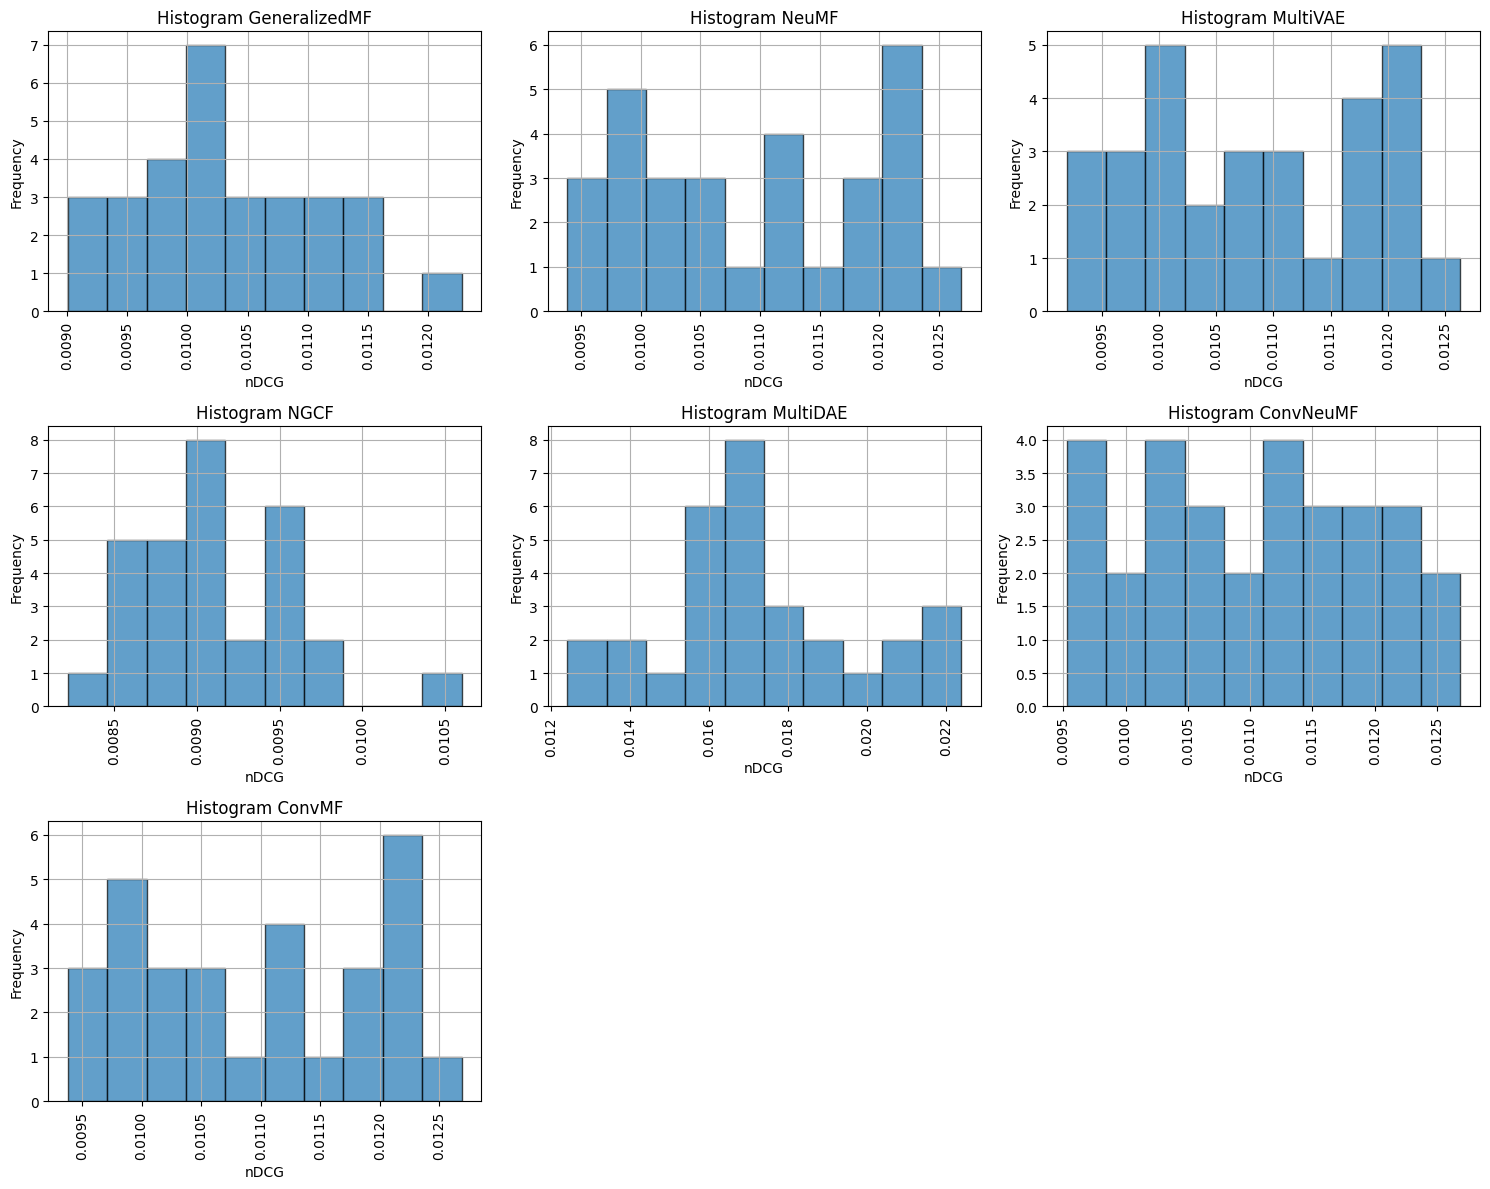

In [19]:
# Disclaimer: This cell was partly generated with the support of a LLM (ChatGPT)


models = df_movielens_experiments["model"].unique()
num_models = len(models)

# Define subplot grid (adjust for readability)
cols = 3  # Number of columns in the subplot grid
rows = int(np.ceil(num_models / cols))  # Calculate rows dynamically

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  
axes = axes.flatten()  # Flatten axes for easy iteration

# Loop through each model and plot the histogram in the corresponding subplot
for i, model in enumerate(models):
    df_plot = df_movielens_experiments[df_movielens_experiments["model"] == model]
    title = model.split("_")[0]  # Extract part of the model name

    axes[i].hist(df_plot["nDCG"], bins=10, alpha=0.7, edgecolor="black")  # Improved histogram
    axes[i].set_title(f"Histogram {title}", fontsize=12)
    axes[i].set_xlabel("nDCG")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)
    axes[i].tick_params(axis = "x",rotation = 90)

# Hide any unused subplots (if total models < grid size)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The results look mostly acceptable again. Again *ConvMF* and *NeuMF* have very similiar distributions.

Perform ttest: 

$$
H_0: \ \mu_{sample} = \mu_0
$$

$$
H_1: \ \mu_{sample} \neq \mu_0
$$

We perform the test at a significance level of $\alpha = 0.05$


In [20]:

# Disclaimer: This Notebook Cell was partly created with an LLM (ChatGPT). It was used to improve the visual output of the test.


# To get rid of pandas warnings
df_movielens_experiments = df_movielens_experiments.copy()
df_movielens_results = df_movielens_results.copy()
df_movielens_experiments.loc[:,"model_name"] = df_movielens_experiments.loc[:,"model"].str.split("_").str[0]
df_movielens_results.loc[:,"model_name"] = df_movielens_results.loc[:,"model"].str.split("_").str[0]

# Create a list to store results
ttest_results = []

for model in df_movielens_experiments["model_name"].unique():
    result = df_movielens_results.loc[df_movielens_results["model_name"] == model, "nDCG"].item() 
    samples = df_movielens_experiments.loc[df_movielens_experiments["model_name"] == model, "nDCG"].to_numpy()
    
    # Perform t-test
    ttest_result = ttest_1samp(a=samples, popmean=result)
    
    # Store formatted results
    ttest_results.append({
        "Model": model,
        "Mean (Sample)": np.round(np.mean(samples), 5),
        "SD (Sample)" : np.round(np.std(samples),5),
        "Pop Mean (nDCG)": np.round(result, 5),
        "T-Statistic": np.round(ttest_result.statistic, 5),
        "p-Value": np.round(ttest_result.pvalue, 5),
        "Degrees of Freedom":(ttest_result.df),
        "Significant (p < 0.05)": "✅" if ttest_result.pvalue < 0.05 else "❌"
    })

# Convert to DataFrame for better display
df_ttest_results = pd.DataFrame(ttest_results)

df_ttest_results.sort_values(by = "Mean (Sample)", ascending=False)



,Model,Mean (Sample),SD (Sample),Pop Mean (nDCG),T-Statistic,p-Value,Degrees of Freedom,Significant (p < 0.05)
4,MultiDAE,0.01726,0.00260,0.07148,-112.35716,0.0,29,✅
5,ConvNeuMF,0.01103,0.00091,0.03713,-154.20034,0.0,29,✅
1,NeuMF,0.01098,0.00099,0.02196,-59.63629,0.0,29,✅
6,ConvMF,0.01098,0.00099,0.02196,-59.63629,0.0,29,✅
2,MultiVAE,0.01085,0.00100,0.00645,23.80201,0.0,29,✅
0,GeneralizedMF,0.01033,0.00077,0.01595,-39.17640,0.0,29,✅
3,NGCF,0.00910,0.00047,0.01351,-50.35295,0.0,29,✅


Again we can reject $H_0$ for all models, meaning our results are significantly different than the ones reported in the paper. 


Compare possible differences between the parameters of the models:

In [21]:
# Disclaimer: This cell was partly generated with the support of a LLM (ChatGPT)


for model in df_movielens_experiments["model_name"].unique():
    
    print("=" * 30)
    print(model)

    model1 = df_movielens_experiments.loc[df_movielens_experiments["model_name"] == model, "model"].unique().item()
    model2 = df_movielens_results.loc[df_movielens_results["model_name"] == model, "model"].unique().item()

    # Use difflib to compare
    diff = list(difflib.ndiff(model1.split("_"), model2.split("_")))

    # Extract and print differences
    differences = []
    for d in diff:
        if d.startswith('- ') or d.startswith('+ '):
            key = d[2:].split("=")[0] if "=" in d else "Unknown"
            value = d[2:].split("=")[1] if "=" in d else d[2:]
            model_source = "Config File" if d.startswith("- ") else "Results File"
            differences.append((key, value, model_source))

    # Print results
    if differences:
        print("Differences found:\n")
        for param, value, model_source in differences:
            print(f"Parameter: {param}")
            print(f"   - {model_source}: {value}\n")
    else:
        print("No Differences Found Between Models")



GeneralizedMF
No Differences Found Between Models
NeuMF
No Differences Found Between Models
MultiVAE
No Differences Found Between Models
NGCF
No Differences Found Between Models
MultiDAE
No Differences Found Between Models
ConvNeuMF
No Differences Found Between Models
ConvMF
No Differences Found Between Models


### Test Amazon


Here we have less samples, as the runs failed multipled times and took longer than for the other datasets.

In [22]:
df_amazon_experiments = df_experiments[df_experiments["experiment"] == "amazon"].copy()
df_amazon_results = df_results[df_results["experiment"] == "amazon"]
df_amazon_results.sort_values("nDCG", ascending=False)

,model,nDCG,experiment,cutoff
47,EASER_neighborhood=10025_l2_norm=2$72,0.076518,amazon,10
43,MultiDAE_seed=42_e=5_bs=1024_intermediate_dim=...,0.003260,amazon,10
44,ConvNeuMF_seed=42_e=10_bs=16_lr=0$06_embedding...,0.002641,amazon,10
42,MultiVAE_seed=42_e=10_bs=256_intermediate_dim=...,0.001620,amazon,10
40,GeneralizedMF_seed=42_e=15_bs=512_lr=0$07_mffa...,0.000719,amazon,10
46,NGCF_seed=42_e=15_bs=512_lr=0$09_factors=64_l_...,0.000612,amazon,10
41,NeuMF_seed=42_e=10_bs=256_lr=0$08_mffactors=25...,0.000437,amazon,10
45,ConvMF_seed=42_e=10_bs=32_lr=0$07_embedding_si...,0.000437,amazon,10


Remove EASER

In [23]:
df_amazon_experiments = df_amazon_experiments[~df_amazon_experiments["model"].str.startswith("EASER")] 
df_amazon_results = df_amazon_results[~df_amazon_results["model"].str.startswith("EASER")]

Look at distributions

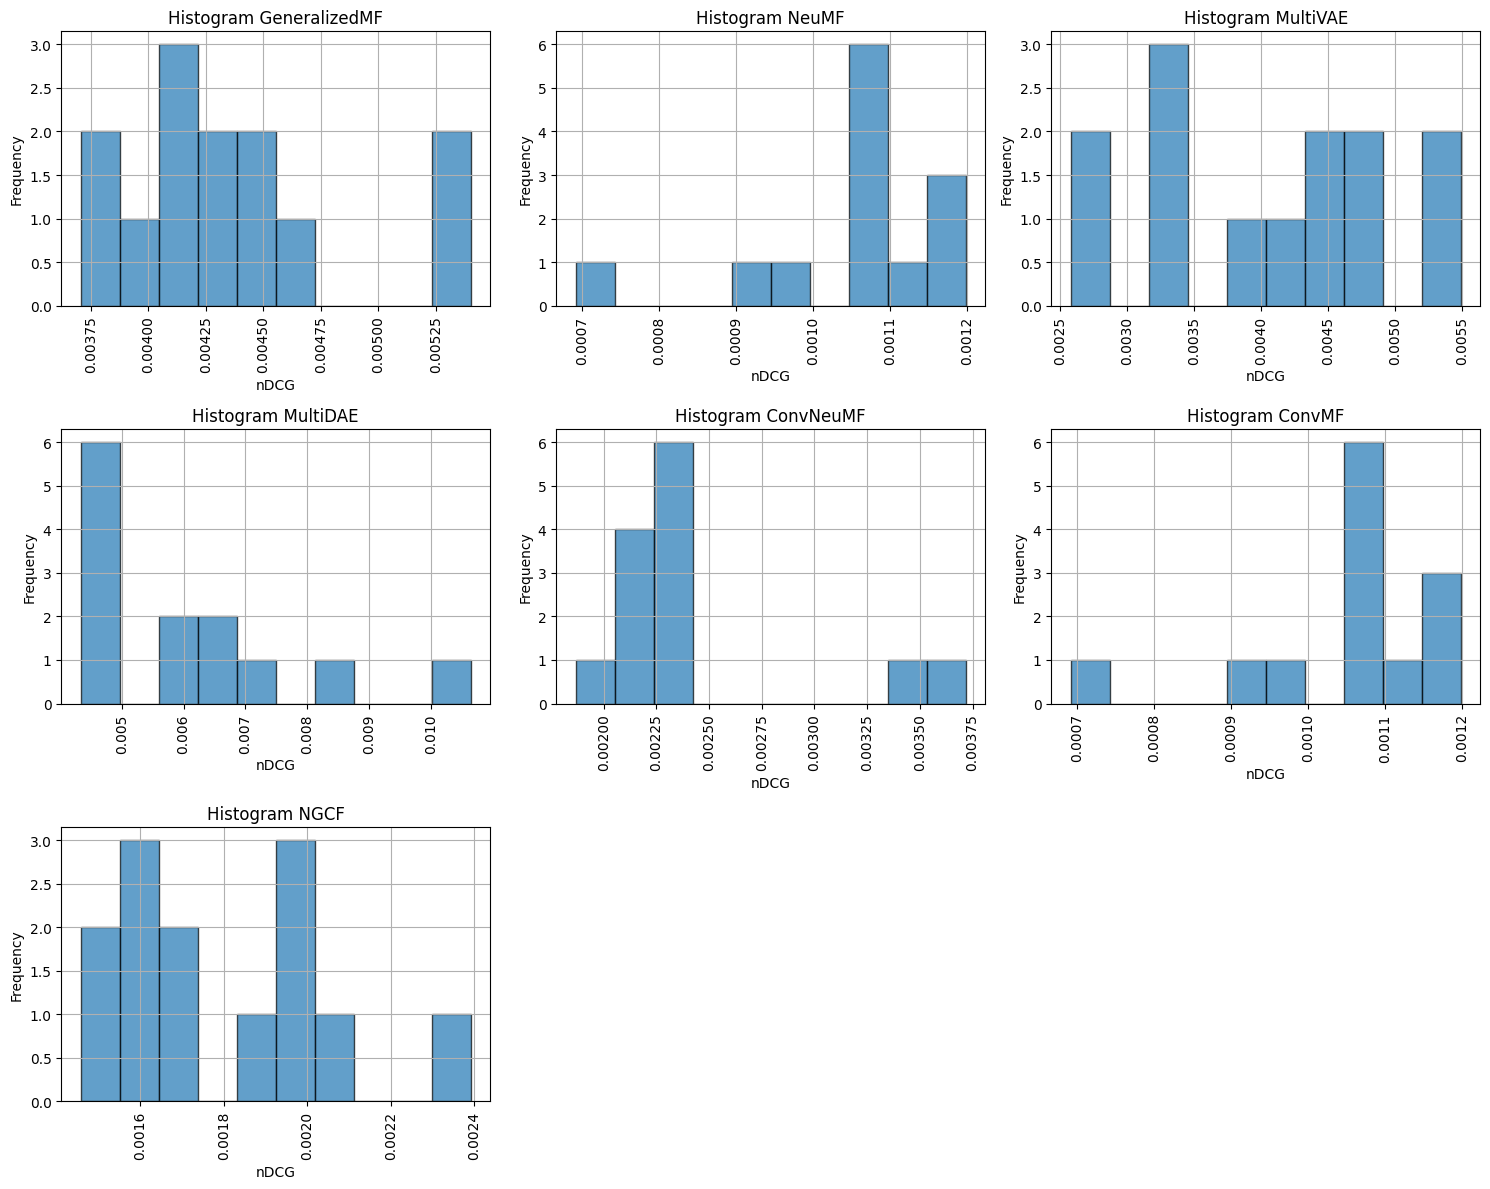

In [24]:
# Disclaimer: This cell was partly generated with the support of a LLM (ChatGPT)


models = df_amazon_experiments["model"].unique()
num_models = len(models)

# Define subplot grid (adjust for readability)
cols = 3  # Number of columns in the subplot grid
rows = int(np.ceil(num_models / cols))  # Calculate rows dynamically

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  
axes = axes.flatten()  # Flatten axes for easy iteration

# Loop through each model and plot the histogram in the corresponding subplot
for i, model in enumerate(models):
    df_plot = df_amazon_experiments[df_amazon_experiments["model"] == model]
    title = model.split("_")[0]  # Extract part of the model name

    axes[i].hist(df_plot["nDCG"], bins=10, alpha=0.7, edgecolor="black")  # Improved histogram
    axes[i].set_title(f"Histogram {title}", fontsize=12)
    axes[i].set_xlabel("nDCG")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)
    axes[i].tick_params(axis = "x",rotation = 90)

# Hide any unused subplots (if total models < grid size)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In these distributions, we can detect some potential outliers, such as in *ConvMF* or *NeuMF* (equal distribution again), which would be another violation of the t-test assumptions. However, as mentioned in the slides, the experiments are robust, and we decided to violate/ignore this assumption in our decision-making process.  

Perform t-test:

$$
H_0: \ \mu_{sample} = \mu_0
$$

$$
H_1: \ \mu_{sample} \neq \mu_0
$$

We perform the test at a significance level of $\alpha = 0.05$

In [25]:

# Disclaimer: This Notebook Cell was partly created with an LLM (ChatGPT). It was used to improve the visual output of the test.


# To get rid of pandas warnings
df_amazon_experiments = df_amazon_experiments.copy()
df_amazon_results = df_amazon_results.copy()
df_amazon_experiments.loc[:,"model_name"] = df_amazon_experiments.loc[:,"model"].str.split("_").str[0]
df_amazon_results.loc[:,"model_name"] = df_amazon_results.loc[:,"model"].str.split("_").str[0]

# Create a list to store results
ttest_results = []

for model in df_amazon_experiments["model_name"].unique():
    result = df_amazon_results.loc[df_amazon_results["model_name"] == model, "nDCG"].item() 
    samples = df_amazon_experiments.loc[df_amazon_experiments["model_name"] == model, "nDCG"].to_numpy()
    
    # Perform t-test
    ttest_result = ttest_1samp(a=samples, popmean=result)
    
    # Store formatted results
    ttest_results.append({
        "Model": model,
        "Mean (Sample)": np.round(np.mean(samples), 5),
        "SD (Sample)" : np.round(np.std(samples),5),
        "Pop Mean (nDCG)": np.round(result, 5),
        "T-Statistic": np.round(ttest_result.statistic, 5),
        "p-Value": np.round(ttest_result.pvalue, 5),
        "Degrees of Freedom":(ttest_result.df),
        "Significant (p < 0.05)": "✅" if ttest_result.pvalue < 0.05 else "❌"
    })

# Convert to DataFrame for better display
df_ttest_results = pd.DataFrame(ttest_results)

df_ttest_results.sort_values("Mean (Sample)", ascending = False)


,Model,Mean (Sample),SD (Sample),Pop Mean (nDCG),T-Statistic,p-Value,Degrees of Freedom,Significant (p < 0.05)
3,MultiDAE,0.00610,0.00178,0.00326,5.53362,0.00013,12,✅
0,GeneralizedMF,0.00438,0.00050,0.00072,25.23671,0.00000,12,✅
2,MultiVAE,0.00402,0.00092,0.00162,9.08045,0.00000,12,✅
4,ConvNeuMF,0.00239,0.00052,0.00264,-1.69575,0.11570,12,❌
6,NGCF,0.00180,0.00026,0.00061,16.11010,0.00000,12,✅
1,NeuMF,0.00105,0.00013,0.00044,16.08625,0.00000,12,✅
5,ConvMF,0.00105,0.00013,0.00044,16.08625,0.00000,12,✅


We can reject $H_0$ except for ConvNeuMF where the difference is not siginificant.

Check possible differences between parameters of the models:

In [26]:
# Disclaimer: This cell was partly generated with the support of a LLM (ChatGPT)


for model in df_amazon_experiments["model_name"].unique():
    
    print("=" * 30)
    print(model)

    model1 = df_amazon_experiments.loc[df_amazon_experiments["model_name"] == model, "model"].unique().item()
    model2 = df_amazon_results.loc[df_amazon_results["model_name"] == model, "model"].unique().item()

    # Use difflib to compare
    diff = list(difflib.ndiff(model1.split("_"), model2.split("_")))

    # Extract and print differences
    differences = []
    for d in diff:
        if d.startswith('- ') or d.startswith('+ '):
            key = d[2:].split("=")[0] if "=" in d else "Unknown"
            value = d[2:].split("=")[1] if "=" in d else d[2:]
            model_source = "Config File" if d.startswith("- ") else "Results File"
            differences.append((key, value, model_source))

    # Print results
    if differences:
        print("Differences found:\n")
        for param, value, model_source in differences:
            print(f"Parameter: {param}")
            print(f"   - {model_source}: {value}\n")
    else:
        print("No Differences Found Between Models")



GeneralizedMF
No Differences Found Between Models
NeuMF
No Differences Found Between Models
MultiVAE
No Differences Found Between Models
MultiDAE
No Differences Found Between Models
ConvNeuMF
No Differences Found Between Models
ConvMF
No Differences Found Between Models
NGCF
No Differences Found Between Models
